# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

In [24]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
#from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [25]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [26]:
# decide whether to save results:
save_results = False

In [27]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in data

In [28]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-18.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

# Data clean

In [29]:
# med data:

# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

# join data
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

# Create response variables, which is visits / population
df['y_hematopoietic'] = 1000 * df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = 1000 * df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = 1000 * df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = 1000 * df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = 1000 * df['number_of_visits_injuries'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month (not used anymore)
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county
df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

In [30]:
# DELETE LATER
# df = df.head(1000)

Function to get a simpler model output

In [31]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

#get_ols_res(fit1).head(1)

# First stage regression - Predict pm2.5 levels

One hot encode

In [32]:
cols_to_encode = ['school_county_v2', 'month', 'year_month_county']
instrum = ['avg_wind_alignment_cosine']
enc1 = OneHotEncoder(handle_unknown = 'ignore')
enc1.fit(df[cols_to_encode])

if save_results:
  enc_file = os.path.join(data_path, '../fitted_models/onehotencoder')
  import pickle
  with open(enc_file, "wb") as f: 
    pickle.dump(enc1, f)

# Load it back in like this:
# with open(enc_file, "rb") as f: 
#   enc = pickle.load(f)


df_encoded = pd.DataFrame(enc1.transform(df[cols_to_encode]).toarray())

all_cols = []
for i,col in enumerate(cols_to_encode):
  res1 = [col+'_'+j for j in enc1.categories_[i]]
  all_cols += res1

df_encoded.columns = all_cols
df_encoded.columns = df_encoded.columns.str.replace("\.*\s+", "_").str.lower()

In [33]:
# get data into right model form
y = df['pm25']
X = pd.concat([df['avg_wind_alignment_cosine'], df_encoded], axis=1)

In [34]:
# fit model
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_pm25'] = fit1.fittedvalues.values

# save model
if save_results:
  fit1.save(os.path.join(data_path, '../fitted_models/stage1_ols.pickle'), remove_data=True)

# Get residuals
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

get_ols_res(fit1).head(3)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,avg_wind_alignment_cosine,0.143102,0.661812,-0.498720,0.784924
1,school_county_v2_alameda,-0.102298,0.830623,-1.040565,0.835968
2,school_county_v2_calaveras,-1.285082,0.186781,-3.194004,0.623840


# Second Stage Regression

- Stage 1 of the least squares regression: $\hat{x} = z \delta$.
  - $\hat{x}$ = Predicted pm2.5 amounts ($\hat{pm2.5}$). We'll use this predicted var to predict our final Y, health outcomes. 
  - $z$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 
  
- Stage 2 of the equation: $\hat{y} = \hat{x} \beta$
  - $\hat{y}$ = predicted medical outcome
  - $\hat{x}$ = predicted pm2.5 amt from the first stage. But we also should include the other exogenous vars. 

In [35]:
X = pd.concat([df['yhat_pm25'], df_encoded], axis=1)

In [36]:
# fit model
fit2_hema = sm.OLS(df['y_hematopoietic'], X).fit()

# save model
if save_results:
  fit2_hema.save(os.path.join(data_path, '../fitted_models/stage2_ols_hematopoietic.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

# Get residuals
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

get_ols_res(fit2_hema).head(3)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,yhat_pm25,0.0,NaN,0.0,0.0
1,school_county_v2_alameda,0.0,NaN,0.0,0.0
2,school_county_v2_calaveras,0.0,NaN,0.0,0.0


In [37]:
# fit model
fit2_vasc = sm.OLS(df['y_vasculitis'], X).fit()

# save model
if save_results:
  fit2_vasc.save(os.path.join(data_path, '../fitted_models/stage2_ols_vasculitis.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

# Get residuals
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

get_ols_res(fit2_vasc).head(3)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,yhat_pm25,-0.002953,0.722232,-0.019253,0.013346
1,school_county_v2_alameda,-0.000362,0.843713,-0.003963,0.003240
2,school_county_v2_calaveras,-0.003899,0.726702,-0.025787,0.017988


In [38]:
# fit model
fit2_diab = sm.OLS(df['y_diabetes'], X).fit()

# save model
if save_results:
  fit2_diab.save(os.path.join(data_path, '../fitted_models/stage2_ols_diabetes.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_diabetes'] = fit2_diab.fittedvalues.values 

# Get residuals
resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

get_ols_res(fit2_diab).head(3)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,yhat_pm25,0.0,NaN,0.0,0.0
1,school_county_v2_alameda,0.0,NaN,0.0,0.0
2,school_county_v2_calaveras,0.0,NaN,0.0,0.0


In [39]:
# fit model
fit2_resp_cardio = sm.OLS(df['y_resp_cardio'], X).fit()

# save model
if save_results:
  fit2_resp_cardio.save(os.path.join(data_path, '../fitted_models/stage2_ols_resp_cardio.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values 

# Get residuals
resids_and_fitted_resp_cardio = pd.DataFrame({'resids': fit2_resp_cardio.resid, 'fitted': fit2_resp_cardio.fittedvalues.values})

get_ols_res(fit2_resp_cardio).head(3)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,yhat_pm25,-1.967606,0.929285,-45.466646,41.531434
1,school_county_v2_alameda,-0.949188,0.846374,-10.560739,8.662362
2,school_county_v2_calaveras,-3.480423,0.906940,-61.892177,54.931332


In [40]:
# fit model
fit2_injuries = sm.OLS(df['y_injuries'], X).fit()

# save model
if save_results:
  fit2_injuries.save(os.path.join(data_path, '../fitted_models/stage2_ols_injuries.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_injuries'] = fit2_injuries.fittedvalues.values 

# Get residuals
resids_and_fitted_injuries = pd.DataFrame({'resids': fit2_injuries.resid, 'fitted': fit2_injuries.fittedvalues.values})

get_ols_res(fit2_injuries).head(3)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,yhat_pm25,-0.858647,0.159485,-2.055494,0.338200
1,school_county_v2_alameda,-0.093812,0.486507,-0.358267,0.170644
2,school_county_v2_calaveras,-1.122270,0.170897,-2.729430,0.484891


# Save data with results

In [ ]:
if save_results:
  df.to_csv(os.path.join(data_path, 'modeling_data/modeling_data_results_2022-10-27.csv'), index=False)

# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


                    wind_bearing   hema_resids   vasc_resids   diab_resids  \
wind_bearing        1.000000e+00 -1.106043e-16  1.071914e-16  5.364000e-17   
hema_resids        -1.106043e-16  1.000000e+00  2.056838e-02  5.797023e-04   
vasc_resids         1.071914e-16  2.056838e-02  1.000000e+00  6.532641e-04   
diab_resids         5.364000e-17  5.797023e-04  6.532641e-04  1.000000e+00   
resp_cardio_resids -4.076764e-17  7.013851e-03  5.849211e-03  6.222753e-02   
injuries_resids     1.870045e-17  5.221488e-03  2.569402e-03  3.462874e-02   

                    resp_cardio_resids  injuries_resids  
wind_bearing             -4.076764e-17     1.870045e-17  
hema_resids               7.013851e-03     5.221488e-03  
vasc_resids               5.849211e-03     2.569402e-03  
diab_resids               6.222753e-02     3.462874e-02  
resp_cardio_resids        1.000000e+00     9.861661e-02  
injuries_resids           9.861661e-02     1.000000e+00  


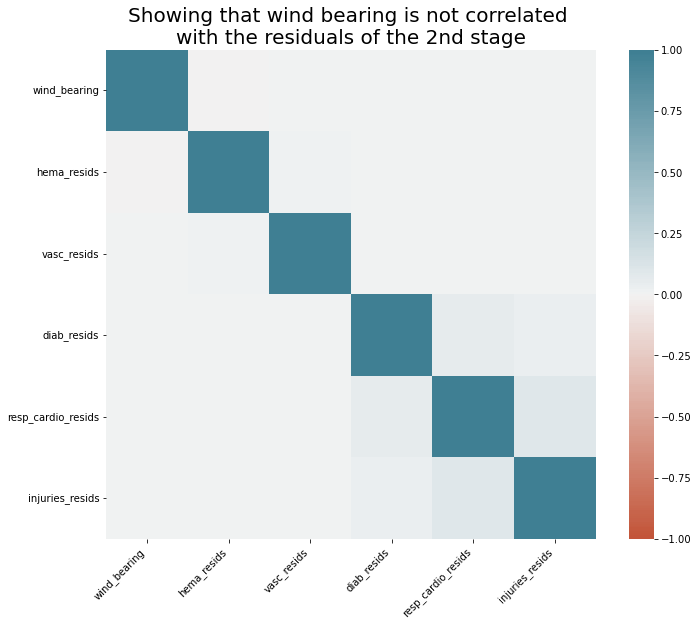

In [66]:
df_corr = pd.DataFrame({
  'wind_bearing': df['avg_wind_alignment_cosine'].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values,
  'resp_cardio_resids': resids_and_fitted_resp_cardio.resids.values,
  'injuries_resids': resids_and_fitted_injuries.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)

# First stage F-test

Run an F test with our instrument to study the impact on the pm2.5. 

In [67]:
# get data into right model form
y, X_null = dmatrices('pm25 ~ 1', data=df, return_type='dataframe')
y, X_instrument = dmatrices('pm25 ~ 1 + avg_wind_alignment_cosine', data=df, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,311162.0,1.114428e+07,0.0,NaN,NaN,NaN
1,311161.0,1.114275e+07,1.0,1526.706847,42.633231,6.612902e-11
